本文件用于将IDL程序画出的狭缝画time-distance图  
以及进一步的DEM图像

In [36]:
import sunpy
import sunpy.map
import numpy as np
from math import *
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sunpy.coordinates import frames
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import ConnectionPatch
import os,cv2
from scipy.optimize import fmin
from scipy.ndimage import affine_transform
import shutil
from scipy.io import readsav
import glob
from matplotlib.patches import Rectangle

In [2]:
data=readsav('D:/Learning/PHD1st/magnetic_reconnecion/program/nfb.sav')
print(data.keys())
slice=data['slice304']
print(slice.shape)
print(slice.max())

dict_keys(['slice304', 'sp', 'ov', 'mul', 'xx', 'yy'])
(164, 34)
3411.0


In [3]:
xx=data['xx']
yy=data['yy']
#这个计算一下平均的纵坐标上的距离
distance=np.zeros(123)
for i in range(123):
    d=np.sqrt((xx[i+1]-xx[i])**2+(yy[i+1]-yy[i])**2)
    distance[i]=d
print(distance.mean())

1.0079638569135854


In [4]:
rsm=fits.open('D:/Learning/PHD1st/magnetic_reconnecion/data/AIA/AIA171/aia.lev1_euv_12s.2024-06-18T195010Z.171.image_lev1.fits')
dsun_obs=rsm[1].header['DSUN_OBS']
resolution=rsm[1].header['CDELT2']
#k是一角秒对应多少千米
k=sin(np.pi/(3600*180))*dsun_obs/1000
print(dsun_obs,'m',resolution,'arc/pixel',k,'km')

151961208544.75787 m 0.599488974 arc/pixel 736.7287290014933 km


In [15]:
#这个corr_a是找到对应yticks的位置
a=[i for i in range(10,80,10)]
corr_a=np.zeros(7)
for i in range(7):
    corr_a[i]=1000*a[i]/(k*resolution*distance.mean())
print(corr_a)

[ 22.46292126  44.92584253  67.38876379  89.85168506 112.31460632
 134.77752759 157.24044885]


因为第7个时刻，也就是21:00:09缺失，所以先插值补充一下

In [ ]:
time_points=np.arange(35)
valid_time_points=np.delete(time_points,7)
inter_slice=np.zeros((125,49))
for row in range(slice.shape[0]):
    f=interp1d(valid_time_points,slice[row,:],kind='cubic',fill_value='extrapolate')
    inter_slice[row,:]=f(time_points)

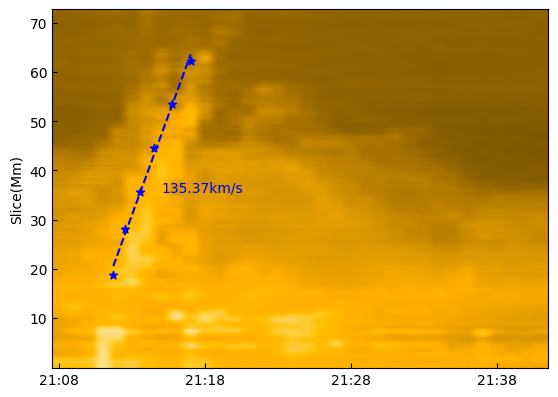

In [39]:
plt.imshow(np.log(slice),cmap='sdoaia171',origin='lower', aspect=0.15,vmin=1.0,vmax=9.0)
plt.yticks(ticks=corr_a,labels=['10','20','30','40','50','60','70'])
plt.xticks(ticks=[0,10,20,30],labels=['21:08','21:18','21:28','21:38'])
plt.tick_params(axis='both',direction='in')
plt.ylabel('Slice(Mm)')
coord1=[(3.7,42),(4.5,63),(5.5,80),(6.5,100),(7.7,120),(9,140)]
x1,y1=zip(*coord1)
x1,y1=np.array(x1),np.array(y1)
plt.scatter(x=x1,y=y1,c='blue',marker='*')
coeff1=np.polyfit(x1,y1,1)
poly1=np.poly1d(coeff1)
plt.plot(x1,poly1(x1),c='blue',linestyle='--')
plt.text(7,80,'135.37km/s',color='blue')
plt.show()

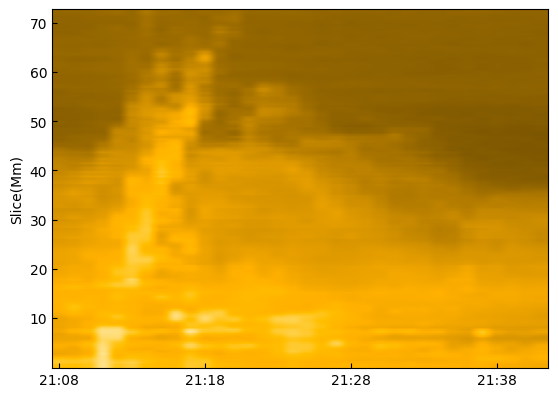

In [40]:
plt.imshow(np.log(slice),cmap='sdoaia171',origin='lower', aspect=0.15,vmin=1.0,vmax=9.0)
plt.yticks(ticks=corr_a,labels=['10','20','30','40','50','60','70'])
plt.xticks(ticks=[0,10,20,30],labels=['21:08','21:18','21:28','21:38'])
plt.tick_params(axis='both',direction='in')
plt.ylabel('Slice(Mm)')
plt.show()

In [36]:
print(coeff1[0]*distance.mean()*resolution*k/(60))

135.3675684274038


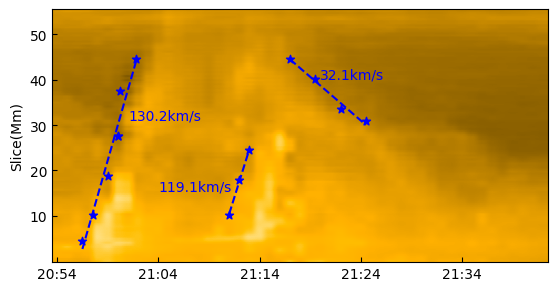

In [113]:
plt.imshow(np.log(inter_slice),cmap='sdoaia171',origin='lower', aspect=0.2,vmin=1.0,vmax=9.0)
plt.yticks(ticks=corr_a,labels=['10','20','30','40','50'])
plt.xticks(ticks=[0,10,20,30,40],labels=['20:54','21:04','21:14','21:24','21:34'])
plt.tick_params(axis='both',direction='in')
plt.ylabel('Slice(Mm)')
coord1=[(2.5,10), (3.5,23), (5,42), (6,62), (6,62),(6.2,84),(7.8,100)]
x1,y1=zip(*coord1)
x1,y1=np.array(x1),np.array(y1)
plt.scatter(x=x1,y=y1,c='blue',marker='*')
coord2=[(17,23),(18,40),(19,55)]
x2,y2=zip(*coord2)
x2,y2=np.array(x2),np.array(y2)
plt.scatter(x=x2,y=y2,c='blue',marker='*')
coord3=[(23,100),(25.5,90),(28,75),(30.5,69)]
x3,y3=zip(*coord3)
x3,y3=np.array(x3),np.array(y3)
plt.scatter(x=x3,y=y3,c='blue',marker='*')
coeff1=np.polyfit(x1,y1,1)
poly1=np.poly1d(coeff1)
plt.plot(x1,poly1(x1),c='blue',linestyle='--')
coeff2=np.polyfit(x2,y2,1)
poly2=np.poly1d(coeff2)
plt.plot(x2,poly2(x2),c='blue',linestyle='--')
coeff3=np.polyfit(x3,y3,1)
poly3=np.poly1d(coeff3)
plt.plot(x3,poly3(x3),c='blue',linestyle='--')
plt.text(7,70,'130.2km/s',color='blue')
plt.text(10,35,'119.1km/s',color='blue')
plt.text(26,90,'32.1km/s',color='blue')
plt.show()

In [96]:
print(coeff1)
print(coeff2)
print(coeff3)

[ 17.48549755 -37.70905846]
[  16.         -248.66666667]
[ -4.32 199.06]


In [100]:
print(coeff1[0]*distance.mean()*resolution*k/(60))
print(coeff2[0]*distance.mean()*resolution*k/(60))
print(coeff3[0]*distance.mean()*resolution*k/(60))

130.15968320555402
119.10184001577994
-32.157496804260596


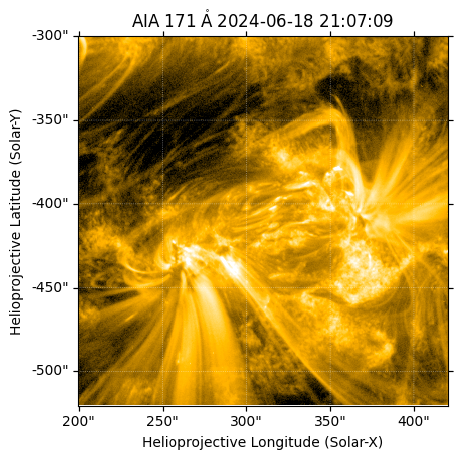

In [91]:
paths='D:/Learning/PHD1st/magnetic_reconnecion/data/AIA/AIA171/aia.lev1_euv_12s.2024-06-18T210710Z.171.image_lev1.fits'
my_maps=sunpy.map.Map(paths)
roi_bottom_left = SkyCoord(Tx=200*u.arcsec, Ty=-300*u.arcsec, frame=my_maps.coordinate_frame)
roi_top_right = SkyCoord(Tx=420*u.arcsec, Ty=-520*u.arcsec, frame=my_maps.coordinate_frame)
my_submap = my_maps.submap(roi_bottom_left, top_right=roi_top_right)
fig = plt.figure()
ax = fig.add_subplot(projection=my_submap)
my_submap.plot(axes=ax, clip_interval=(1, 99.9)*u.percent,cmap='sdoaia171')
plt.show()

In [42]:
path='D:/Learning/PHD1st/magnetic_reconnecion/program/DEM18-Jun-2024_21_07_06.sav'
data=readsav(path)

In [44]:
result=data['result']

In [54]:
dem_out=result['DEM_OUT'][0]
smap_temp=result['SMAP_TEMP'][0]
smap_em=result['SMAP_EM'][0]

In [56]:
print(smap_temp.shape)

(183, 183)


In [93]:
data=np.log(my_submap.data)
print(data.min())
print(data.max())

3.988984
9.289059


(-0.5, 182.5, -0.5, 182.5)

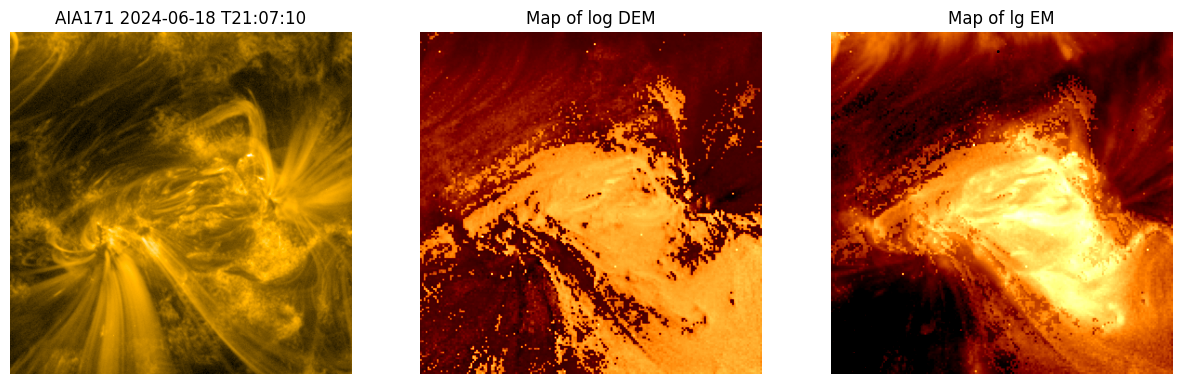

In [97]:
fig = plt.figure(figsize=(15, 5))

# 第一个子图
plt.subplot(131)
plt.imshow(data,cmap='sdoaia171',origin='lower',vmin=4.0,vmax=9)
plt.axis('off')
plt.title('AIA171 2024-06-18 T21:07:10')
ax2=plt.subplot(132)
plt.imshow(np.log(smap_temp),cmap='afmhot',origin='lower')
plt.title('Map of log DEM')
plt.axis('off')
ax3=plt.subplot(133)
plt.imshow(np.log(smap_em),cmap='afmhot',origin='lower',vmin=61.5,vmax=65.4)
plt.title('Map of lg EM')
plt.axis('off')
#plt.colorbar()

In [76]:
print(np.log(smap_em).max())
print(np.log(smap_em).min())

65.52783
59.833134


(-0.5, 182.5, -0.5, 182.5)

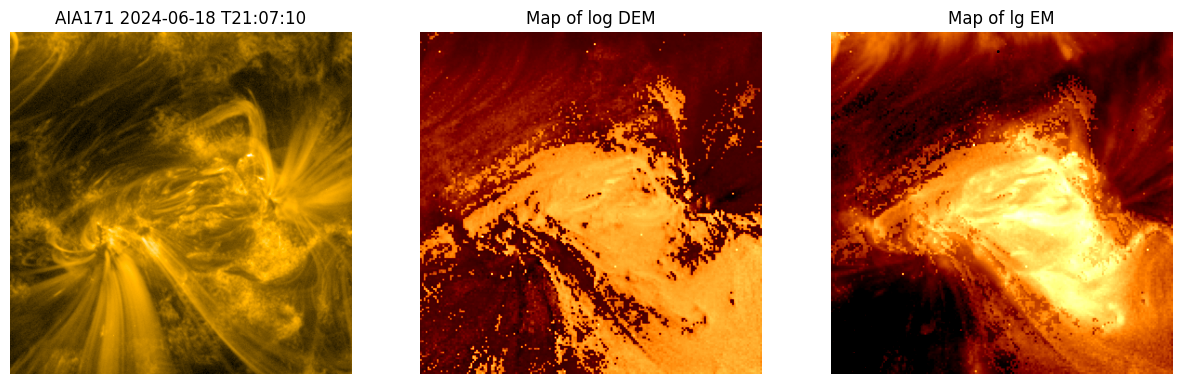

In [105]:
paths='D:/Learning/PHD1st/magnetic_reconnecion/data/AIA/AIA171/aia.lev1_euv_12s.2024-06-18T210710Z.171.image_lev1.fits'
my_maps=sunpy.map.Map(paths)
roi_bottom_left = SkyCoord(Tx=200*u.arcsec, Ty=-300*u.arcsec, frame=my_maps.coordinate_frame)
roi_top_right = SkyCoord(Tx=420*u.arcsec, Ty=-520*u.arcsec, frame=my_maps.coordinate_frame)
my_submap = my_maps.submap(roi_bottom_left, top_right=roi_top_right)

path='D:/Learning/PHD1st/magnetic_reconnecion/program/DEM18-Jun-2024_21_07_06.sav'
datas=readsav(path)
result=datas['result']
dem_out=result['DEM_OUT'][0]
smap_temp=result['SMAP_TEMP'][0]
smap_em=result['SMAP_EM'][0]

fig = plt.figure(figsize=(15, 5))

# 第一个子图
plt.subplot(131)
plt.imshow(np.log(my_submap.data),cmap='sdoaia171',origin='lower',vmin=4.0,vmax=9)
plt.axis('off')
plt.title('AIA171 2024-06-18 T21:07:10')
ax2=plt.subplot(132)
plt.imshow(np.log(smap_temp),cmap='afmhot',origin='lower')
plt.title('Map of log DEM')
plt.axis('off')
ax3=plt.subplot(133)
plt.imshow(np.log(smap_em),cmap='afmhot',origin='lower',vmin=61.5,vmax=65.4)
plt.title('Map of lg EM')
plt.axis('off')

(-0.5, 182.5, -0.5, 182.5)

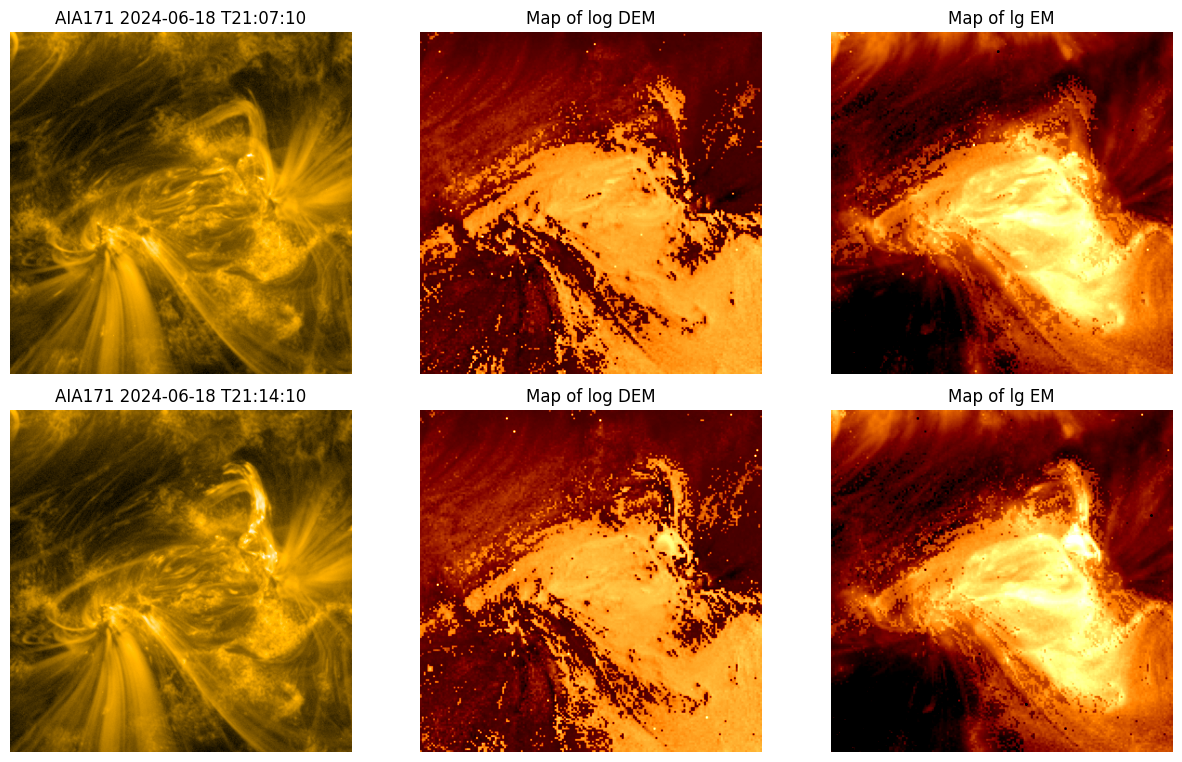

In [109]:
paths2='D:/Learning/PHD1st/magnetic_reconnecion/data/AIA/AIA171/aia.lev1_euv_12s.2024-06-18T211410Z.171.image_lev1.fits'
my_maps2=sunpy.map.Map(paths2)
roi_bottom_left2 = SkyCoord(Tx=200*u.arcsec, Ty=-300*u.arcsec, frame=my_maps.coordinate_frame)
roi_top_right2 = SkyCoord(Tx=420*u.arcsec, Ty=-520*u.arcsec, frame=my_maps.coordinate_frame)
my_submap2 = my_maps2.submap(roi_bottom_left2, top_right=roi_top_right2)

path2='D:/Learning/PHD1st/magnetic_reconnecion/program/DEM18-Jun-2024_21_14_06.sav'
datas2=readsav(path2)
result2=datas2['result']
dem_out2=result2['DEM_OUT'][0]
smap_temp2=result2['SMAP_TEMP'][0]
smap_em2=result2['SMAP_EM'][0]

fig = plt.figure(figsize=(15, 18))
# 第一个子图
plt.subplot(131)
plt.imshow(np.log(my_submap.data),cmap='sdoaia171',origin='lower',vmin=4.0,vmax=9)
plt.axis('off')
plt.title('AIA171 2024-06-18 T21:07:10')
ax2=plt.subplot(132)
plt.imshow(np.log(smap_temp),cmap='afmhot',origin='lower')
plt.title('Map of log DEM')
plt.axis('off')
ax3=plt.subplot(133)
plt.imshow(np.log(smap_em),cmap='afmhot',origin='lower',vmin=61.5,vmax=65.4)
plt.title('Map of lg EM')
plt.axis('off')
# 第一个子图
plt.subplot(234)
plt.imshow(np.log(my_submap2.data),cmap='sdoaia171',origin='lower',vmin=4.0,vmax=9)
plt.axis('off')
plt.title('AIA171 2024-06-18 T21:14:10')
ax2=plt.subplot(235)
plt.imshow(np.log(smap_temp2),cmap='afmhot',origin='lower')
plt.title('Map of log DEM')
plt.axis('off')
ax3=plt.subplot(236)
plt.imshow(np.log(smap_em2),cmap='afmhot',origin='lower',vmin=61.5,vmax=65.4)
plt.title('Map of lg EM')
plt.axis('off')

__<font color='cyan' size=5>因为直接用map2fits会导致header里CUNIT1本来是'arcsec'变成'arcsecs'，所以改一下</font>__  
改完发现还是不行，还是缺东西，无语了，不知道该怎么保存为fits了

In [ ]:
from astropy.io import fits

# 读取 FITS 文件
input_filename=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rot\\'+'rot_aia*.fits')
for i in range(20):
# 打开 FITS 文件
    with fits.open(input_filename[i], mode='update') as hdul:
        # 获取第一个扩展的 Header
        header = hdul[0].header  # 如果是其他扩展，请更改索引

        # 修改 Header 中的 CUNIT1 项
        header['CUNIT1'] = 'arcsec'  # 设置为新的单位值
        header['CUNIT2'] = 'arcsec'  
        output_filename=r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rott\\'+input_filename[i][-55:]
        # 保存修改到新的文件
        hdul.writeto(output_filename, overwrite=True)

    print(f"Modified CUNIT1 and saved to {output_filename}")


D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rott\aia.lev1_euv_12s.2024-06-18T210708Z.131.image_lev1.fits
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


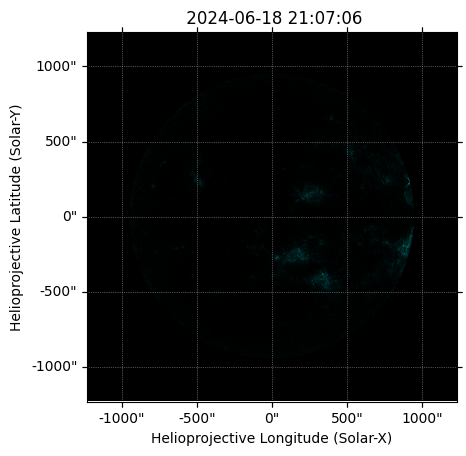

In [17]:
dir=r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rott\\'
file=glob.glob(dir+'*.fits')
print(file[0])
my_maps=sunpy.map.Map(file[0])
my_maps.plot(cmap='sdoaia131')

In [3]:
from scipy.io import readsav

# 读取 IDL 保存的 .sav 文件
data = readsav(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\\'+'rot_sub_aia_171.sav', python_dict=True)

# 提取保存的结构
matrix_struct = data['matrix_struct']

# 遍历结构，提取每个矩阵
matrices = []
for i, entry in enumerate(matrix_struct):
    matrix = entry['matrix'].astype(float)  # 提取矩阵并转换为 NumPy 数组
    matrices.append(matrix)
    #print(f"Matrix {i}: Shape {matrix.shape}")


In [41]:
time_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rott\\'+'*.fits')
file_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\program\DEM\\'+'*.sav')
for i in range(20):
    datas=readsav(file_list[i])
    result=datas['result']
    dem_out=result['DEM_OUT'][0]
    smap_temp=result['SMAP_TEMP'][0]
    smap_em=result['SMAP_EM'][0]
    fig = plt.figure(figsize=(15, 5))
    gs=gridspec.GridSpec(5,15,wspace=0.5,hspace=0)
    ax1=fig.add_subplot(gs[0:5,1:5])
    plt.imshow(np.log1p(matrices[i]),cmap='sdoaia131',origin='lower',vmin=0.5,vmax=6)
    plt.axis('off')
    plt.title(time_list[i][-38:-21])
    ax2=fig.add_subplot(gs[0:5,5:10])
    plt.imshow(np.log10(smap_temp),cmap='jet',origin='lower')
    left_bottom=(90,138)#x,y
    rect=Rectangle(left_bottom,10,10,edgecolor='black',facecolor='none')#x,y
    ax2.add_patch(rect)
    plt.title('Map of log temperature')
    plt.axis('off')
    plt.colorbar()
    ax3=fig.add_subplot(gs[0:5,10:15])
    plt.imshow(np.log10(smap_em),cmap='jet',origin='lower',vmin=26.5,vmax=29)
    rect=Rectangle(left_bottom,10,10,edgecolor='black',facecolor='none')#x,y
    ax3.add_patch(rect)
    plt.title('Map of log EM')
    plt.axis('off')
    plt.colorbar()
    plt.savefig(r'D:\Learning\PHD1st\AIA\AIAdem\\'+time_list[i][-38:-21]+'.png',dpi=300)
    plt.close()


C:\Users\19671\AppData\Local\Temp\ipykernel_7964\523201541.py:12: RuntimeWarning: divide by zero encountered in log1p
  plt.imshow(np.log1p(matrices[i]),cmap='sdoaia131',origin='lower',vmin=0.5,vmax=6)
C:\Users\19671\AppData\Local\Temp\ipykernel_7964\523201541.py:12: RuntimeWarning: invalid value encountered in log1p
  plt.imshow(np.log1p(matrices[i]),cmap='sdoaia131',origin='lower',vmin=0.5,vmax=6)
C:\Users\19671\AppData\Local\Temp\ipykernel_7964\523201541.py:16: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(smap_temp),cmap='jet',origin='lower')
C:\Users\19671\AppData\Local\Temp\ipykernel_7964\523201541.py:24: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(smap_em),cmap='jet',origin='lower',vmin=26.5,vmax=29)


In [91]:
print(np.log10(20))
print(np.log(20)/np.log(10))

1.3010299956639813
1.301029995663981


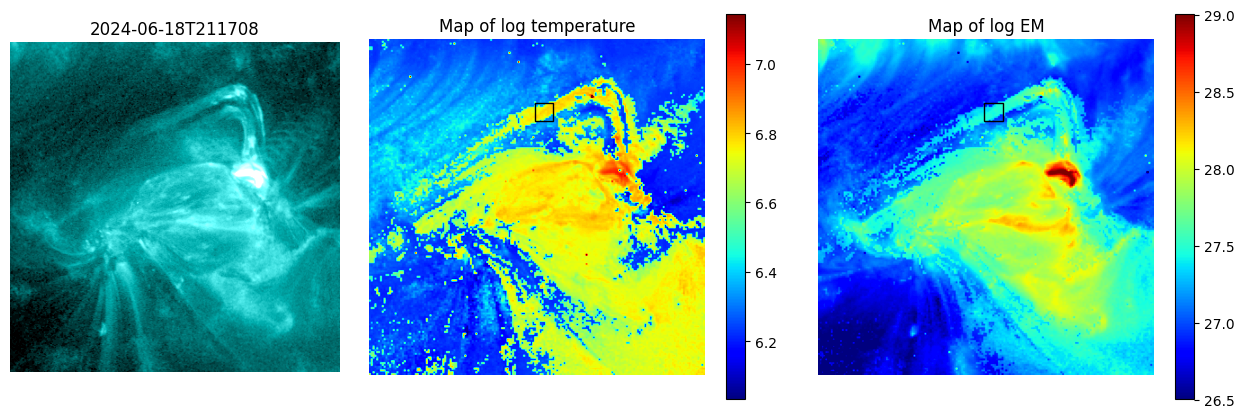

In [42]:
i=10
datas=readsav(file_list[i])
result=datas['result']
dem_out=result['DEM_OUT'][0]
smap_temp=result['SMAP_TEMP'][0]
smap_em=result['SMAP_EM'][0]
fig = plt.figure(figsize=(17, 5))
gs=gridspec.GridSpec(5,15,wspace=0.5,hspace=0)
ax1=fig.add_subplot(gs[0:5,1:5])
plt.imshow(np.log1p(matrices[i]),cmap='sdoaia131',origin='lower',vmin=0.5,vmax=6)
plt.axis('off')
plt.title(time_list[i][-38:-21])
ax2=fig.add_subplot(gs[0:5,5:10])
plt.imshow(np.log10(smap_temp),cmap='jet',origin='lower',vmax=0.82*np.log10(smap_temp).max())
left_bottom=(90,138)#x,y
rect=Rectangle(left_bottom,10,10,edgecolor='black',facecolor='none')#x,y
ax2.add_patch(rect)
plt.title('Map of log temperature')
plt.axis('off')
plt.colorbar()
ax3=fig.add_subplot(gs[0:5,10:15])
plt.imshow(np.log10(smap_em),cmap='jet',origin='lower',vmin=26.5,vmax=29)
plt.title('Map of log EM')
plt.colorbar()
rect=Rectangle(left_bottom,10,10,edgecolor='black',facecolor='none')#x,y
ax3.add_patch(rect)
plt.axis('off')
plt.savefig(r'D:\Learning\PHD1st\AIA\AIAdem\\'+time_list[i][-38:-21]+'.png',dpi=300)

In [53]:
time_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\data\AIA\AIA131rott\\'+'*.fits')
file_list=glob.glob(r'D:\Learning\PHD1st\magnetic_reconnecion\program\DEM\\'+'*.sav')
avg_temp=np.zeros(20)
avg_em=np.zeros(20)
all_smap_temp=[]
all_smap_em=[]
all_dem_out=[]
for i in range(20):
    datas=readsav(file_list[i])
    result=datas['result']
    dem_out=result['DEM_OUT'][0]
    smap_temp=result['SMAP_TEMP'][0]
    smap_em=result['SMAP_EM'][0]
    all_smap_temp.append(smap_temp)
    all_smap_em.append(smap_em)
    all_dem_out.append(dem_out)
    avg_temp[i]=np.mean(smap_temp[138:148,90:100])
    avg_em[i]=np.mean(smap_em[138:148,90:100])

Text(0.5, 1.0, 'Average Temperature and EM in Rectangular Region')

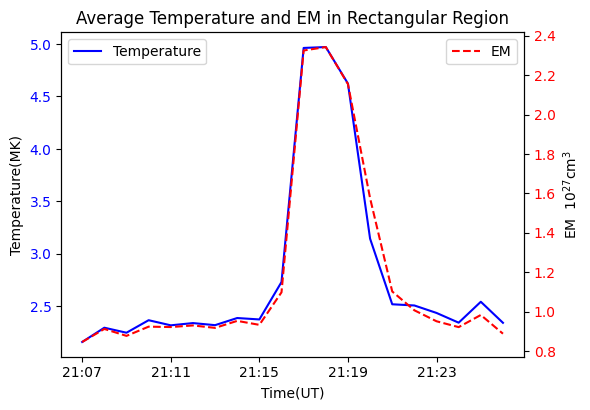

In [83]:
fig,ax1=plt.subplots(figsize=(6,4))
ax1.plot((avg_temp)/1e6,'b-',label='Temperature')
ax1.set_xlabel('Time(UT)')
ax1.set_ylabel('Temperature(MK)')
ax1.set_xticks(ticks=[0,4,8,12,16],labels=['21:07','21:11','21:15','21:19','21:23'])
ax1.tick_params(axis='y',labelcolor='b')
ax2=ax1.twinx()
ax2.plot(avg_em/1e27,'r--',label='EM')
ax2.set_ylabel('EM  '+ r'$10^{27} \text{cm}^3$')
ax2.tick_params(axis='y',labelcolor='r')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
# 显示图形
plt.tight_layout()
plt.title('Average Temperature and EM in Rectangular Region')

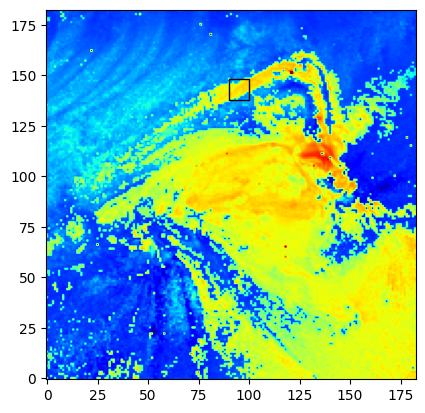

In [39]:
plt.imshow(np.log10(smap_temp),cmap='jet',origin='lower',vmax=0.82*np.log10(smap_temp).max())
left_bottom=(90,138)#x,y
ax=plt.gca()
rect=Rectangle(left_bottom,10,10,edgecolor='black',facecolor='none')#x,y
ax.add_patch(rect)

In [85]:
avg_dem=np.zeros((20,21))
for i in range(20):
    www=all_dem_out[i][:,138:148,90:100]
    avg_dem[i,:]=np.mean(www,axis=(1,2))

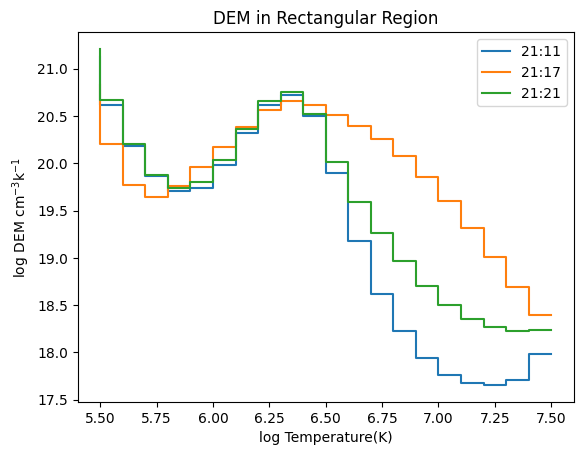

In [97]:
x=np.arange(5.5,7.6,0.1)
plt.step(x,np.log10(avg_dem[6,:]),label='21:11')
plt.step(x,np.log10(avg_dem[10,:]),label='21:17')
plt.step(x,np.log10(avg_dem[14,:]),label='21:21')
plt.xlabel('log Temperature(K)')
plt.ylabel('log DEM '+r'$ \text{cm}^{-3} \text{k}^{-1}$')
plt.title('DEM in Rectangular Region')
plt.legend()